# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file, process_file_jasper



# parameters

In [4]:
# _fname = "../replays/local-8-82-2.3.log"
_fname = "../replays/local-berry.log"
_time_step = 100
_max_time = 3000000
_symbols = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR", "BAGUETTE", "DIP", "UKULELE", "PICNIC_BASKET"]
_products = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR", "BAGUETTE", "DIP", "UKULELE", "PICNIC_BASKET"]

print("_fname", _fname)


_fname ../replays/local.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__g_s", end_sep="__g_e")
# obj = process_file(_fname, start_sep="__g_s", end_sep="__g_e")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/local.log
convert [('"DOLPHIN_SIGHTINGS"', '!0'), ('"market_trades"', '!1'), ('"PICNIC_BASKET"', '!2'), ('"observations"', '!3'), ('"denomination"', '!4'), ('"PINA_COLADAS"', '!5'), ('"sell_orders"', '!6'), ('"DIVING_GEAR"', '!7'), ('"own_trades"', '!8'), ('"buy_orders"', '!9'), ('"SUBMISSION"', '@0'), ('"timestamp"', '@1'), ('"quantity"', '@2'), ('"position"', '@3'), ('"COCONUTS"', '@4'), ('"BAGUETTE"', '@5'), ('"product"', '@6'), ('"UKULELE"', '@7'), ('"BERRIES"', '@8'), ('"BANANAS"', '@9'), ('"symbol"', '$0'), ('"seller"', '$1'), ('"PEARLS"', '$2'), ('"price"', '$3'), ('"buyer"', '$4'), ('"turn"', '$5'), ('"DIP"', '$6')]
num missing_times 18485
missing_times [1151500, 1151600, 1151700, 1151800, 1151900, 1152000, 1152100, 1152200, 1152300, 1152400, 1152500, 1152600, 1152700, 1152800, 1152900, 1153000, 1153100, 1153200, 1153300, 1153400, 1153500, 1153600, 1153700, 1153800, 1153900, 1154000, 1154100, 1154200, 1154300, 1154400, 1154500, 1154600, 115470

In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__t_s", end_sep="__t_e")
raw_records = pd.DataFrame(obj)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_records["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))

Reading from input file ../replays/local.log
convert [('"DOLPHIN_SIGHTINGS"', '!0'), ('"market_trades"', '!1'), ('"PICNIC_BASKET"', '!2'), ('"observations"', '!3'), ('"denomination"', '!4'), ('"PINA_COLADAS"', '!5'), ('"sell_orders"', '!6'), ('"DIVING_GEAR"', '!7'), ('"own_trades"', '!8'), ('"buy_orders"', '!9'), ('"SUBMISSION"', '@0'), ('"timestamp"', '@1'), ('"quantity"', '@2'), ('"position"', '@3'), ('"COCONUTS"', '@4'), ('"BAGUETTE"', '@5'), ('"product"', '@6'), ('"UKULELE"', '@7'), ('"BERRIES"', '@8'), ('"BANANAS"', '@9'), ('"symbol"', '$0'), ('"seller"', '$1'), ('"PEARLS"', '$2'), ('"price"', '$3'), ('"buyer"', '$4'), ('"turn"', '$5'), ('"DIP"', '$6')]
num missing_times 17201
missing_times [1279900, 1280000, 1280100, 1280200, 1280300, 1280400, 1280500, 1280600, 1280700, 1280800, 1280900, 1281000, 1281100, 1281200, 1281300, 1281400, 1281500, 1281600, 1281700, 1281800, 1281900, 1282000, 1282100, 1282200, 1282300, 1282400, 1282500, 1282600, 1282700, 1282800, 1282900, 1283000, 128310

In [7]:
# finish turns
display(raw_df[["finish_turn"]].T)

,0,1,2,3,4,5,6,7,8,9,...,11505,11506,11507,11508,11509,11510,11511,11512,11513,11514
finish_turn,-1,0,1,2,3,4,5,6,7,8,...,11504,11505,11506,11507,11508,11509,11510,11511,11512,11513


### total runtime

In [8]:
# show total runtime of program
display(raw_records[["wall_time", "process_time"]].sum().to_frame())

display(raw_records[["wall_time", "process_time"]].max().to_frame())

,0
wall_time,30.8928
process_time,30.7371


,0
wall_time,0.0351
process_time,0.0351


### add turns

In [9]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### ref_stat_df
- the EMA values that were calculated during the program
- quote_mids during program
- fair valeus calculated during program

In [10]:
# # ref_emas contains EMA values that were used during the program
# ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
# ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

# ref_ema_df = ref_emas.melt(id_vars=["time"], var_name="symbol", value_name="ref_ema") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)


In [11]:
# # large_quote_mid
# quote_mids = raw_records["quote_mids"].apply(pd.Series)
# quote_mids = pd.concat([quote_mids, raw_records["time"]], axis=1)

# quote_mid_df = quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="quote_mid") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)


# # large_quote_mid
# use_quote_mids = raw_records["use_quote_mids"].apply(pd.Series)
# use_quote_mids = pd.concat([use_quote_mids, raw_records["time"]], axis=1)

# use_quote_mid_df = use_quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="use_quote_mid") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)



In [12]:
raw_records

,fair_values,history_len,my_orders,process_time,time,wall_time
0,"{'BAGUETTE': 12000.0, 'BANANAS': 4873.5, 'BERR...",1,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0036,0,0.0036
1,"{'BAGUETTE': 12002.0, 'BANANAS': 4873.5, 'BERR...",2,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0036,100,0.0036
2,"{'BAGUETTE': 12002.5, 'BANANAS': 4873.0, 'BERR...",3,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0036,200,0.0036
3,"{'BAGUETTE': 12003.5, 'BANANAS': 4871.5, 'BERR...",4,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0035,300,0.0035
4,"{'BAGUETTE': 12003.5, 'BANANAS': 4872.0, 'BERR...",5,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0036,400,0.0036
...,...,...,...,...,...,...
12794,"{'BAGUETTE': 12161.5, 'BANANAS': 4828.0, 'BERR...",12795,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0014,1279400,0.0014
12795,"{'BAGUETTE': 12164.5, 'BANANAS': 4827.5, 'BERR...",12796,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0014,1279500,0.0014
12796,"{'BAGUETTE': 12164.5, 'BANANAS': 4827.5, 'BERR...",12797,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0013,1279600,0.0013
12797,"{'BAGUETTE': 12164.5, 'BANANAS': 4827.0, 'BERR...",12798,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0014,1279700,0.0014


In [13]:
fair_values = raw_records["fair_values"].apply(pd.Series)
fair_values = pd.concat([fair_values, raw_records["time"]], axis=1)

fair_value_df = fair_values.melt(id_vars=["time"], var_name="symbol", value_name="fair_value") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [14]:
ref_stat_df = pd.concat([
#     ref_ema_df.set_index(["time", "symbol"]),
#     quote_mid_df.set_index(["time", "symbol"]),
#     use_quote_mid_df.set_index(["time", "symbol"]),
    fair_value_df.set_index(["time", "symbol"]),
], axis=1).reset_index()

### book_tops

#### modify raw_df["book"] to be all ints

In [15]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [16]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []
missing mids COCONUTS []
missing mids PINA_COLADAS []
missing mids BERRIES []
missing mids DIVING_GEAR []
missing mids BAGUETTE []
missing mids DIP []
missing mids UKULELE []
missing mids PICNIC_BASKET []


In [17]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 11515
Remaining count: 11515
nan count: 0


In [18]:
book_tops

,BAGUETTE_best_buy,BAGUETTE_best_sell,BAGUETTE_mid,BAGUETTE_spread,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,...,PICNIC_BASKET_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,UKULELE_best_buy,UKULELE_best_sell,UKULELE_mid,UKULELE_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,11999.0,12001.0,12000.0,2.0,4871.0,4877.0,4874.0,6.0,3916.0,3923.0,...,14.0,15013.0,15016.0,15014.5,3.0,20999.0,21001.0,21000.0,2.0,0
1,12001.0,12003.0,12002.0,2.0,4875.0,4877.0,4876.0,2.0,3916.0,3923.0,...,11.0,15012.0,15013.0,15012.5,1.0,21002.0,21004.0,21003.0,2.0,100
2,12002.0,12003.0,12002.5,1.0,4870.0,4876.0,4873.0,6.0,3916.0,3923.0,...,12.0,15015.0,15018.0,15016.5,3.0,21008.0,21009.0,21008.5,1.0,200
3,12003.0,12004.0,12003.5,1.0,4873.0,4875.0,4874.0,2.0,3916.0,3923.0,...,14.0,15014.0,15017.0,15015.5,3.0,21000.0,21001.0,21000.5,1.0,300
4,12003.0,12005.0,12004.0,2.0,4870.0,4871.0,4870.5,1.0,3917.0,3924.0,...,11.0,15012.0,15015.0,15013.5,3.0,21000.0,21001.0,21000.5,1.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11510,12238.0,12240.0,12239.0,2.0,4810.0,4816.0,4813.0,6.0,3858.0,3865.0,...,11.0,14871.0,14873.0,14872.0,2.0,20954.0,20955.0,20954.5,1.0,1151000
11511,12238.0,12240.0,12239.0,2.0,4809.0,4816.0,4812.5,7.0,3858.0,3865.0,...,11.0,14864.0,14867.0,14865.5,3.0,20952.0,20954.0,20953.0,2.0,1151100
11512,12237.0,12239.0,12238.0,2.0,4809.0,4816.0,4812.5,7.0,3857.0,3864.0,...,13.0,14865.0,14866.0,14865.5,1.0,20950.0,20951.0,20950.5,1.0,1151200


In [19]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [20]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [21]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

""" start of filtering """

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
# my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


# ## old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
# end of old filter methods

""" end of filtering """

trade_df = pd.concat([market_trades, my_trades])

sum_cols = ["quantity", "my_quantity"]

# aggregate quantity over similar trades
trade_df = trade_df.groupby(list(set(trade_df.columns) - set(sum_cols)))[sum_cols].sum().reset_index()[trade_df.columns]
trade_df = trade_df.sort_values(by=["time", "symbol"]).reset_index(drop=True)


# sort by time
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)

# add ref_stats to trade_df
trade_df = trade_df.merge(ref_stat_df, left_on=["order_time", "symbol"], right_on=["time", "symbol"], suffixes=(None, "_ignore"))
trade_df = trade_df.drop("time_ignore", axis=1)
trade_df["buy_edge"] = trade_df["fair_value"] - trade_df["price"]

my_trades = trade_df[trade_df["is_me"]].copy()
market_trades = trade_df[~trade_df["is_me"]].copy()



In [22]:
market_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
0,Paris,4875.0,1,Charlie,BANANAS,100,100,1,False,False,False,0,False,4873.5,-1.5
2,Paris,10002.0,1,Charlie,PEARLS,100,100,1,False,False,False,0,False,10001.5,-0.5
4,Paris,4876.0,1,Charlie,BANANAS,200,200,2,False,False,False,0,False,4873.0,-3.0
6,Paris,7002.0,9,Camilla,DIP,200,200,2,False,False,False,0,False,7002.0,0.0
7,Paris,10004.0,1,Caesar,PEARLS,200,200,2,False,False,False,0,False,10000.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22928,Paris,20951.0,4,Caesar,UKULELE,1150900,1150900,11509,False,False,False,0,False,20950.0,-1.0
22929,Caesar,14871.0,24,Caesar,PINA_COLADAS,1151000,1151000,11510,False,False,False,0,False,14872.0,1.0
22930,Caesar,14871.0,5,Pablo,PINA_COLADAS,1151000,1151000,11510,False,False,False,0,False,14872.0,1.0
22931,Charlie,4811.0,3,Caesar,BANANAS,1151300,1151300,11513,False,False,False,0,False,4812.0,1.0


### volume summary

In [23]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 3484 	volume: 10256
[MY]	 count: 3617 	volume: 10389
[MY]	 vol%: 50.32%
PEARLS
[THEM]	 count: 2891 	volume: 6045
[MY]	 count: 3332 	volume: 8152
[MY]	 vol%: 57.42%
COCONUTS
[THEM]	 count: 383 	volume: 9386
[MY]	 count: 220 	volume: 16412
[MY]	 vol%: 63.62%
PINA_COLADAS
[THEM]	 count: 308 	volume: 3296
[MY]	 count: 219 	volume: 10934
[MY]	 vol%: 76.84%
BERRIES
[THEM]	 count: 737 	volume: 6243
[MY]	 count: 620 	volume: 5029
[MY]	 vol%: 44.61%
DIVING_GEAR
[THEM]	 count: 830 	volume: 1604
[MY]	 count: 5 	volume: 50
[MY]	 vol%: 3.02%
BAGUETTE
[THEM]	 count: 1098 	volume: 6258
[MY]	 count: 595 	volume: 5825
[MY]	 vol%: 48.21%
DIP
[THEM]	 count: 1321 	volume: 9381
[MY]	 count: 595 	volume: 11656
[MY]	 vol%: 55.41%
UKULELE
[THEM]	 count: 1147 	volume: 3871
[MY]	 count: 260 	volume: 1652
[MY]	 vol%: 29.91%
PICNIC_BASKET
[THEM]	 count: 676 	volume: 2118
[MY]	 count: 595 	volume: 2912
[MY]	 vol%: 57.89%


### my_position validation

In [24]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0

# add time/turn to my_positions, sort positions by time
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
cur_pos_data = []
cur_positions = { prod: 0 for prod in _products }
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

# init cur_turn
cur_turn = 0

def record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data):
    """
    For a given 'cur_turn', records the positions (calculated from my trades)
    
    """
    
    global my_positions
    
    # copy orig pos
    cur_pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_time = turn2time_map[cur_turn]
        
    ### init fixed_positions for this turn
    
    # loop through all products
    for prod in _products:
        # look at difference between expected position, and actual "fixed_position"
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        # report this issue
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        # fix the position 
        fixed_positions[prod] += diff
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]


# sort my_trades
my_trades = my_trades.sort_values(by=["time"])
    
# loop through each of our trades
for index, row in my_trades.iterrows():
    # time of current trade
    
    # iterate until right before this trade occurs
    while cur_turn < row["turn"]:
        # record this position data as the "final position" for the times before this trade
        record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
        # increment the time
        cur_turn += 1
        
    # this trade's product
    prod = listings[row["symbol"]]["product"]
    
    # update current positions
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed positions
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_turn < len(turn2time_map):
    record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
    cur_turn += 1

# record this data for the last turn
# record_pos_data(cur_positions, fixed_positions, cur_time, cur_pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)

# calculate total cash by summing all columns
pos_df["total_cash"] = 0
for prod in _products:
    pos_df["total_cash"] = pos_df["total_cash"] + pos_df[f"{prod}_cash"]

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
my_positions = my_positions.sort_index(axis=1)

# sanity check our positions
for prod in _products:
    bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
    if len(bad_inds) > 0:
        print("true pos")
        display(my_positions.loc[bad_inds])
        print("calculated pos")
        display(pos_df.loc[bad_inds])
        assert False, f"Failed check for product: `{prod}`"

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [25]:
# estimate fairs
fairs = fair_values.set_index("time").reindex(np.arange(0, _max_time, _time_step)) \
            .ffill().bfill().reset_index()


# mid_cols = [col for col in book_tops.columns if "_mid" in col]
# fairs = book_tops[["time", *mid_cols]]
# fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BAGUETTE,BANANAS,BERRIES,COCONUTS,DIP,DIVING_GEAR,PEARLS,PICNIC_BASKET,PINA_COLADAS,UKULELE
0,0,12000.0,4873.5,3919.5,8004.5,7000.0,98904.0,10000.0,73365.0,15014.0,21000.0
1,100,12002.0,4873.5,3919.5,8003.5,7001.5,98899.5,10001.5,73383.5,15012.0,21003.0
2,200,12002.5,4873.0,3919.5,8004.5,7002.0,98899.5,10000.0,73385.0,15016.0,21008.0
3,300,12003.5,4871.5,3919.5,8004.5,7003.0,98895.0,10000.0,73371.0,15015.5,21001.0
4,400,12003.5,4872.0,3920.5,8003.5,7002.0,98909.0,10000.0,73343.0,15013.5,21000.0
...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,12163.5,4827.5,3861.0,7893.5,7116.0,99978.5,10000.0,74016.0,14851.0,20733.0
29996,2999600,12163.5,4827.5,3861.0,7893.5,7116.0,99978.5,10000.0,74016.0,14851.0,20733.0
29997,2999700,12163.5,4827.5,3861.0,7893.5,7116.0,99978.5,10000.0,74016.0,14851.0,20733.0
29998,2999800,12163.5,4827.5,3861.0,7893.5,7116.0,99978.5,10000.0,74016.0,14851.0,20733.0


### Estimate PNLs

In [26]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [27]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

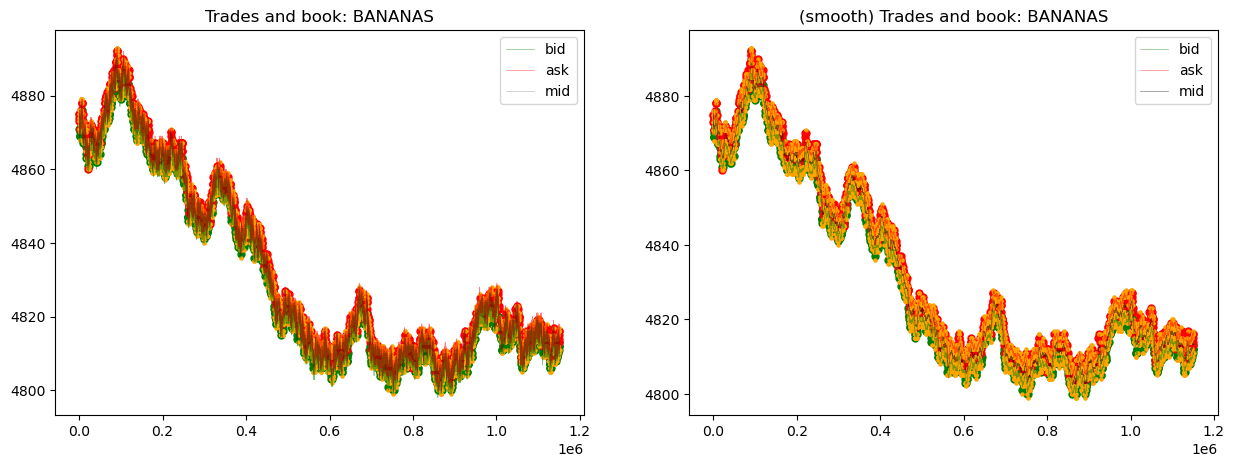

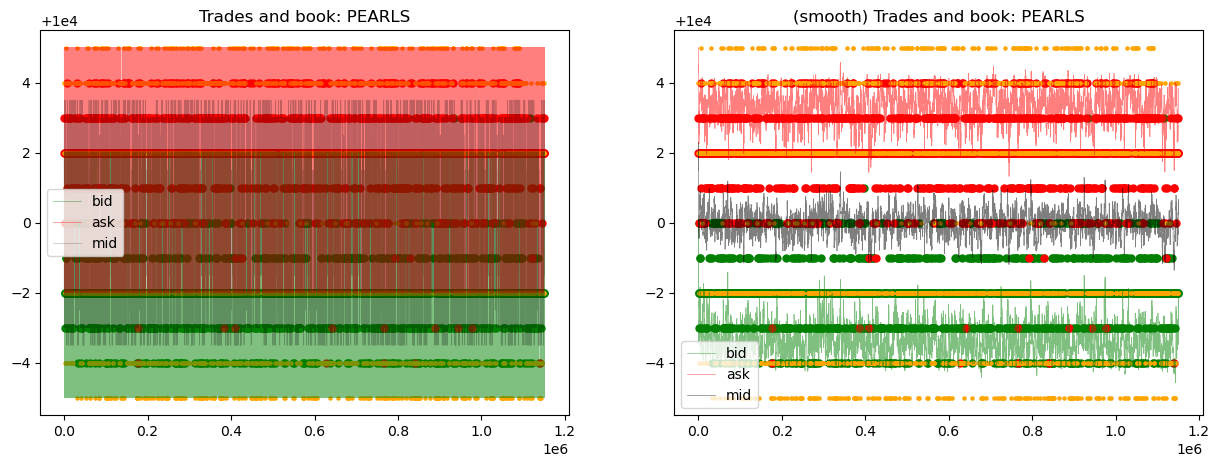

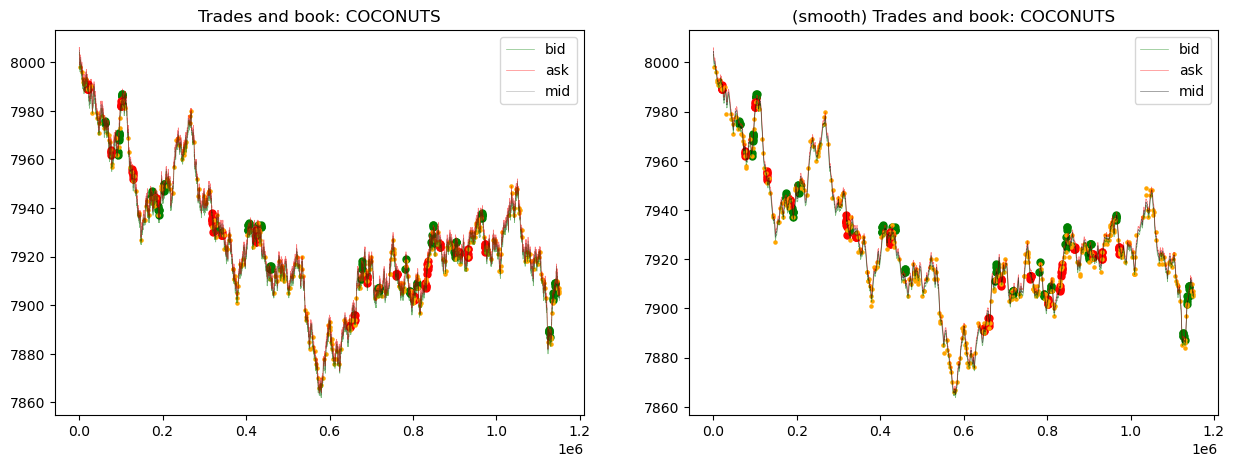

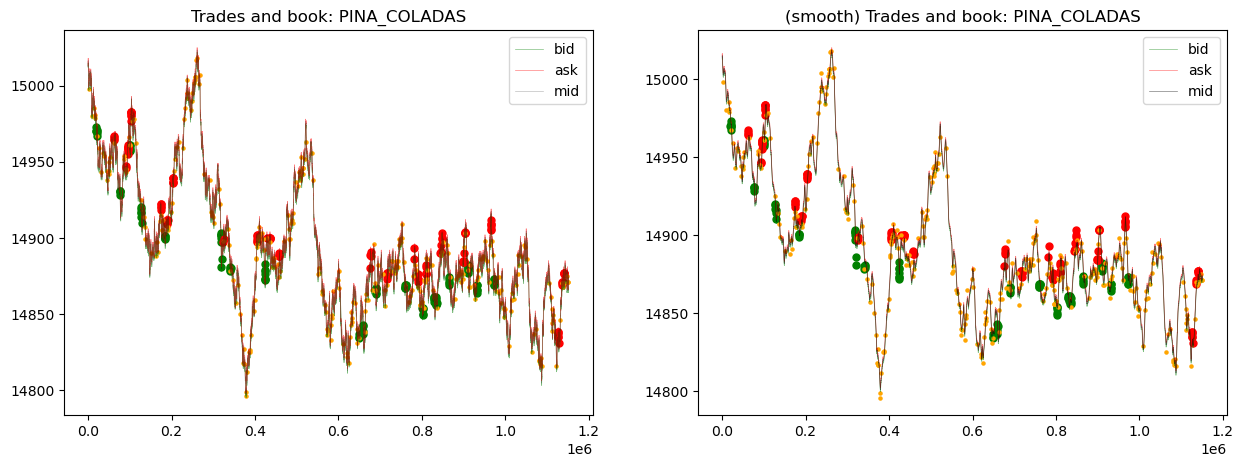

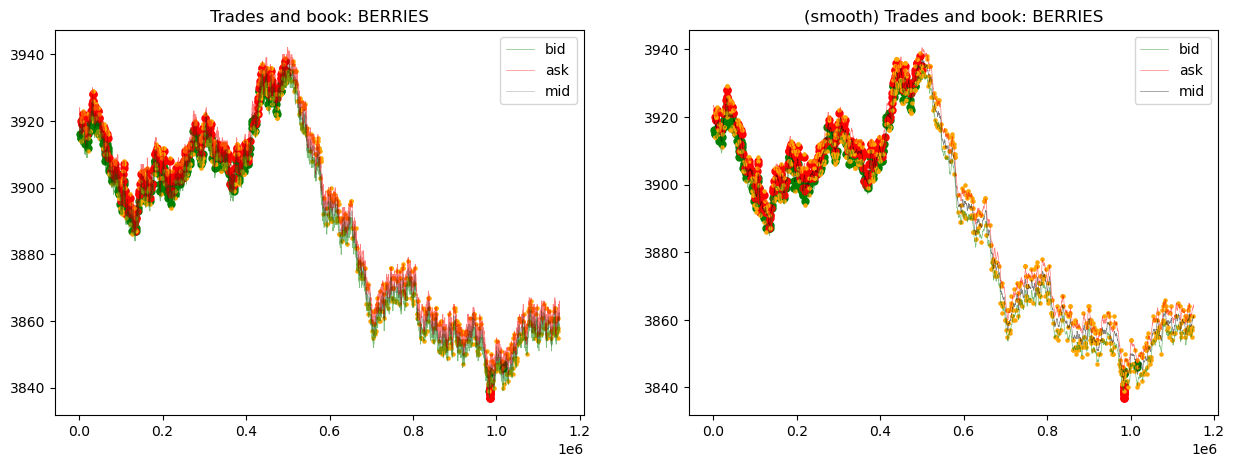

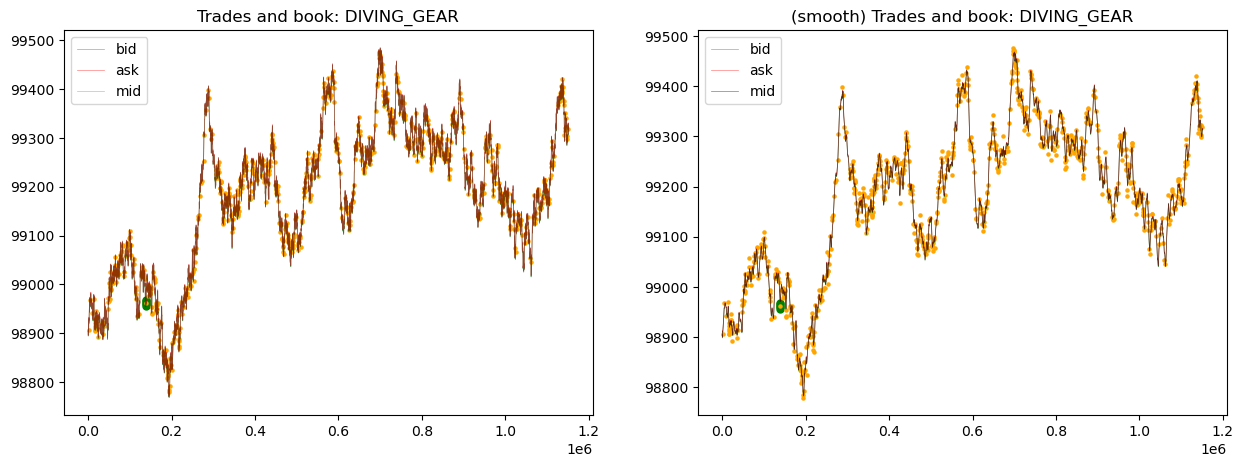

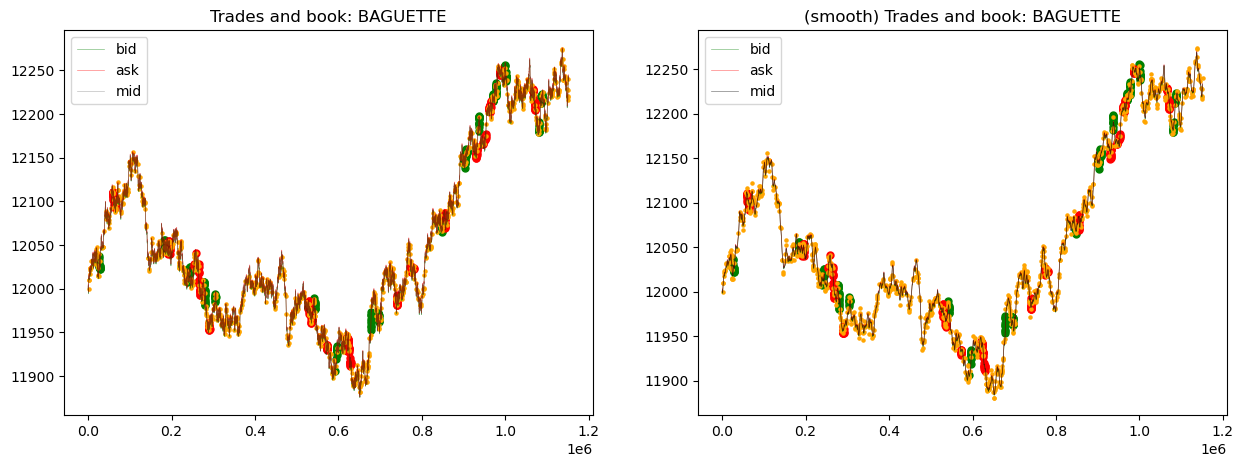

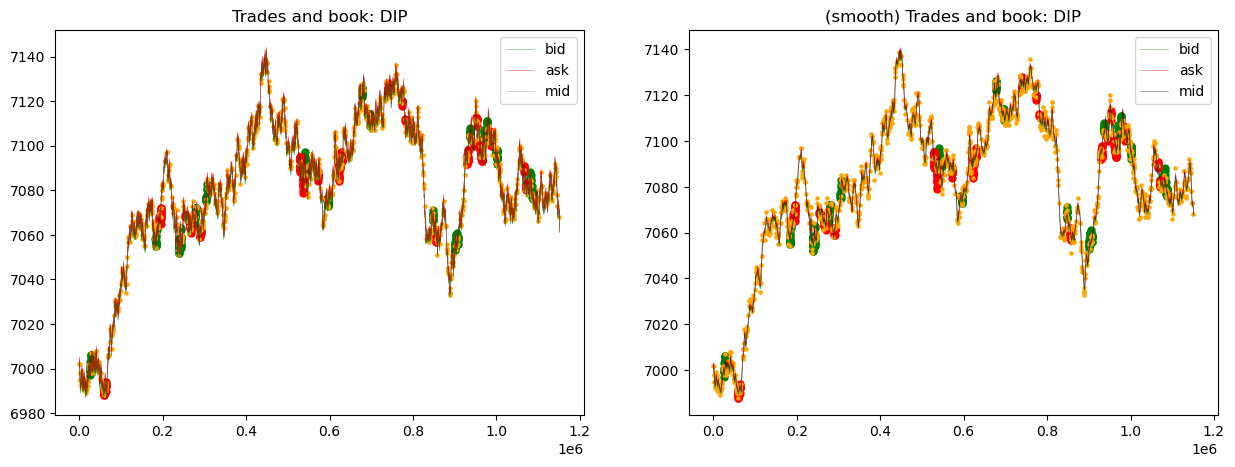

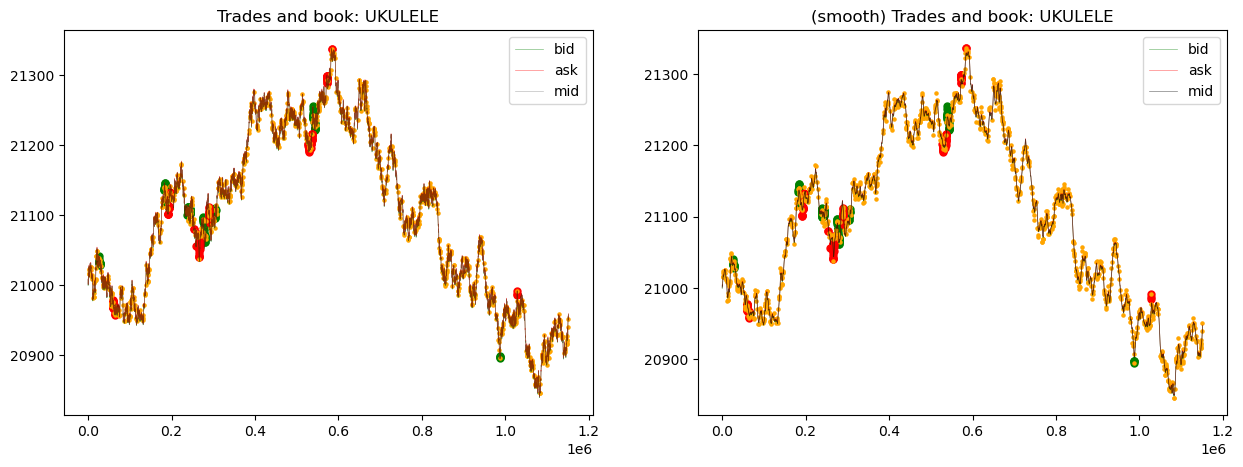

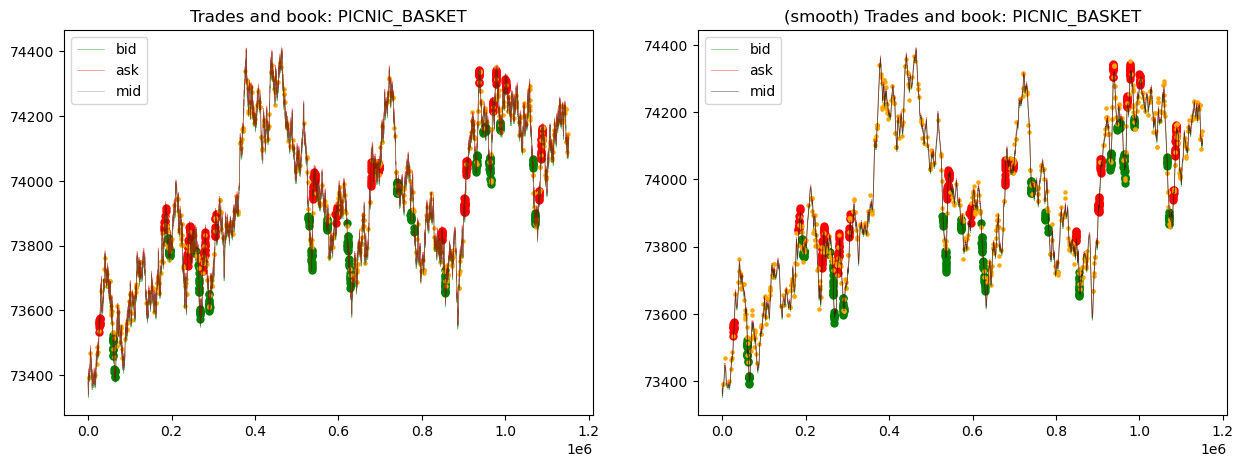

In [28]:
for sym in _symbols:
    plot_trades_and_book(
        sym=sym, 
        trade_df=trade_df, 
        book_df=book_tops, 
    #     time_lb=0, 
    #     time_ub=50000, 
        span=21,
        show_mid=True,
    )

### PNL Graph

Text(0.5, 1.0, 'PNL')

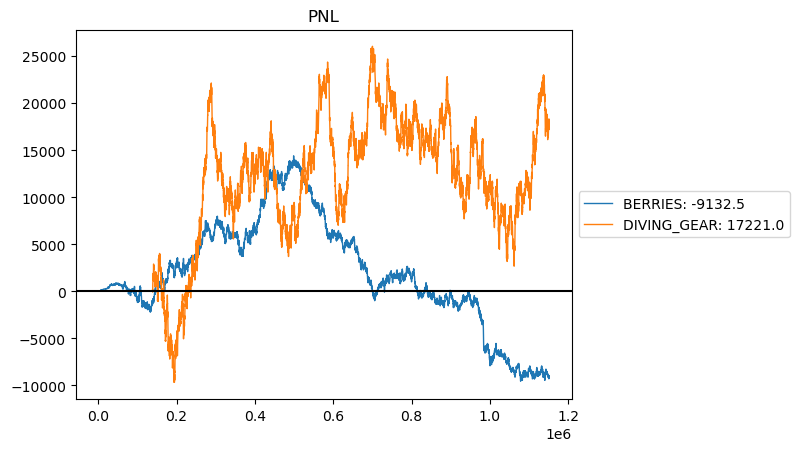

In [29]:
# pnl

# calc pnl from coco/pina pair
my_positions["COCO_PINA_pnl"] = my_positions["COCONUTS_pnl"] + my_positions["PINA_COLADAS_pnl"]

my_positions["BASKET_COMP_pnl"] = my_positions["BAGUETTE_pnl"] + my_positions["DIP_pnl"] + my_positions["UKULELE_pnl"]

my_positions["BASKET_NET_pnl"] = my_positions["BASKET_COMP_pnl"] + my_positions["PICNIC_BASKET_pnl"]

## shown products

products_shown = ["BERRIES", "DIVING_GEAR"]
# products_shown = ["BAGUETTE", "DIP", "UKULELE", "BASKET_COMP", "PICNIC_BASKET", "BASKET_NET"]
# products_shown = ["total", *_products]

# ### basket trade
# for prod in ["DIP", "BAGUETTE", "UKULELE", "PICNIC_BASKET"]:
#     products_shown.remove(prod)
# # products_shown += ["BASKET_COMP"]
# products_shown += ["BASKET_NET"]
    
# ### pina/coco section
# products_shown.remove("COCONUTS")
# products_shown.remove("PINA_COLADAS")
# products_shown += ["COCO_PINA"]


for prod in products_shown:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)

plt.axhline(y=0, color="black")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(f"PNL")


In [30]:
market_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
0,Paris,4875.0,1,Charlie,BANANAS,100,100,1,False,False,False,0,False,4873.5,-1.5
2,Paris,10002.0,1,Charlie,PEARLS,100,100,1,False,False,False,0,False,10001.5,-0.5
4,Paris,4876.0,1,Charlie,BANANAS,200,200,2,False,False,False,0,False,4873.0,-3.0
6,Paris,7002.0,9,Camilla,DIP,200,200,2,False,False,False,0,False,7002.0,0.0
7,Paris,10004.0,1,Caesar,PEARLS,200,200,2,False,False,False,0,False,10000.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22928,Paris,20951.0,4,Caesar,UKULELE,1150900,1150900,11509,False,False,False,0,False,20950.0,-1.0
22929,Caesar,14871.0,24,Caesar,PINA_COLADAS,1151000,1151000,11510,False,False,False,0,False,14872.0,1.0
22930,Caesar,14871.0,5,Pablo,PINA_COLADAS,1151000,1151000,11510,False,False,False,0,False,14872.0,1.0
22931,Charlie,4811.0,3,Caesar,BANANAS,1151300,1151300,11513,False,False,False,0,False,4812.0,1.0


### Positions Graph

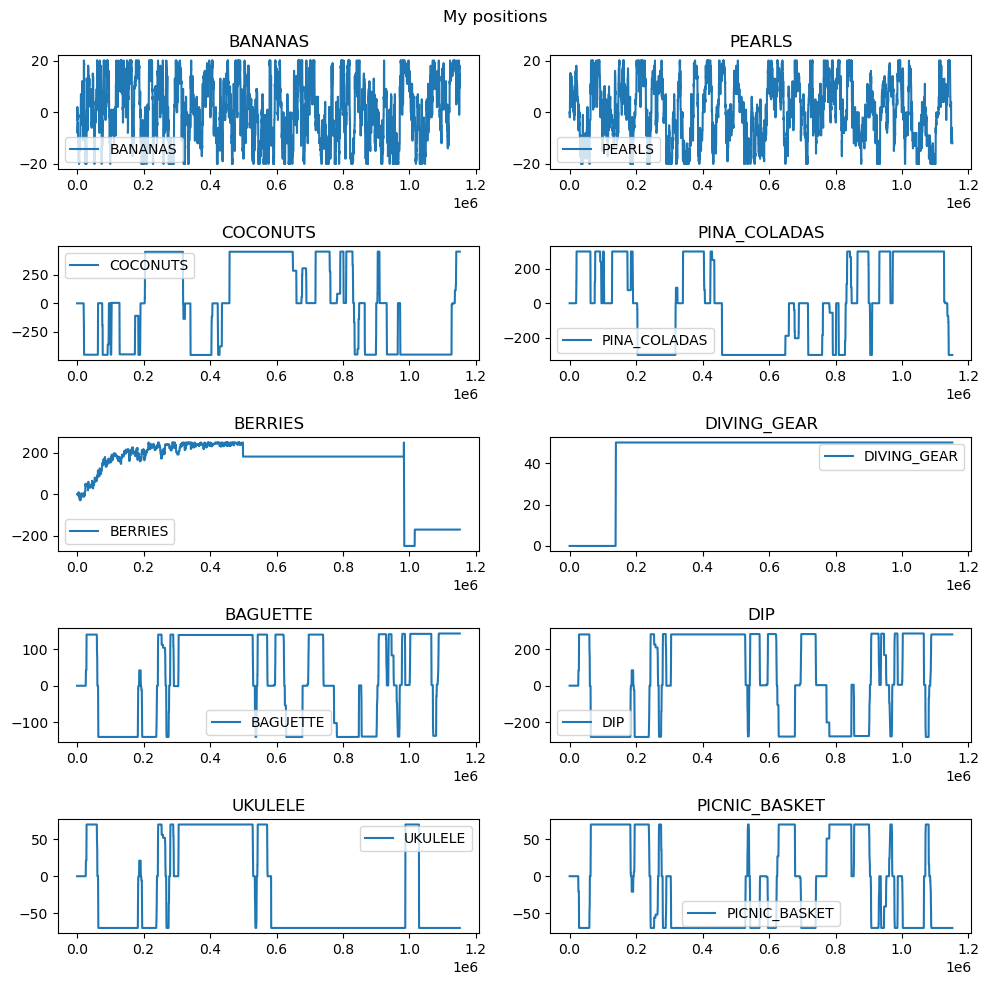

In [31]:
# plot my positions in each product

plt.figure(figsize=(10, 10))

for sym_i, sym in enumerate(_symbols):
    plt.subplot(5, 2, sym_i+1)
    plt.plot(my_positions["time"], my_positions[sym], label=sym)
    plt.title(sym)
    plt.legend()
    
    
plt.suptitle("My positions")
plt.tight_layout()
plt.show()

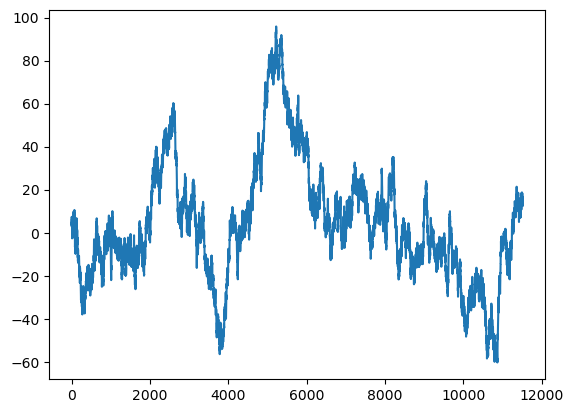

In [32]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.55131931e+00, 2.59237689e+03])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

### Pina-coco error plot

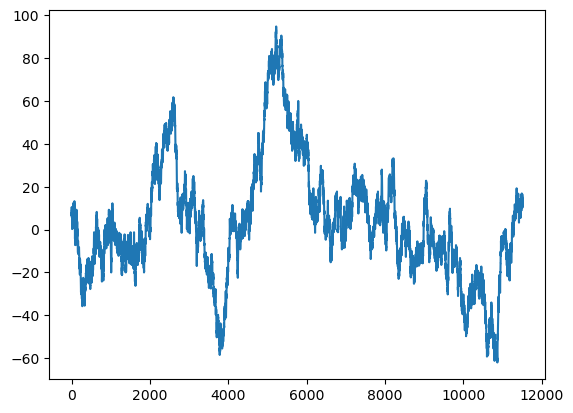

In [33]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.5, 3000])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

In [34]:
# pina-coco exposures
diffs = my_positions["PINA_COLADAS"] + my_positions["COCONUTS"] * 1.5
diffs.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,11515.0,-2.590881,317.102037,-376.5,-372.0,1.5,375.0,379.5


(array([4173.,   58.,   42.,  218.,  711., 2052.,   47.,   24.,  269.,
        3921.]),
 array([-376.5, -300.9, -225.3, -149.7,  -74.1,    1.5,   77.1,  152.7,
         228.3,  303.9,  379.5]),
 <BarContainer object of 10 artists>)

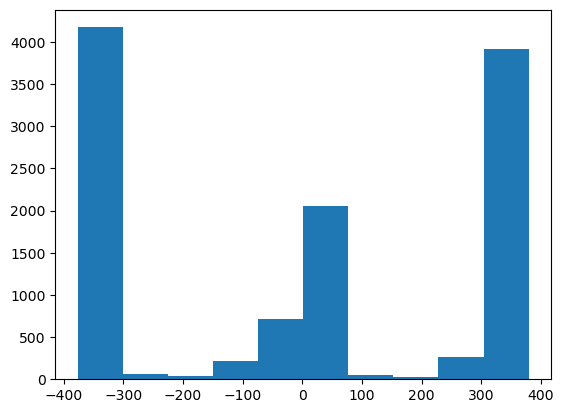

In [35]:
plt.hist(diffs)

In [36]:
my_positions[["PINA_COLADAS", "COCONUTS"]]

,PINA_COLADAS,COCONUTS
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
11510,-300,452
11511,-300,452
11512,-300,452
11513,-300,452


### Price movements (actual change)

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,11514.0,-0.005211,1.668714,-6.5,-1.0,0.0,1.0,6.5
PEARLS_mid,11514.0,0.000130,2.121540,-7.0,-1.0,0.0,1.0,7.0
COCONUTS_mid,11514.0,-0.008815,0.896002,-3.5,-0.5,0.0,0.5,4.0
PINA_COLADAS_mid,11514.0,-0.012680,2.151965,-9.0,-1.5,0.0,1.5,9.5
BERRIES_mid,11514.0,-0.005037,1.058142,-5.0,-0.5,0.0,0.5,5.0
DIVING_GEAR_mid,11514.0,0.035044,6.199089,-22.0,-4.0,0.0,4.0,24.5
BAGUETTE_mid,11514.0,0.020888,2.304347,-8.5,-1.5,0.0,1.5,9.0
DIP_mid,11514.0,0.005341,1.152225,-5.0,-1.0,0.0,1.0,4.5
UKULELE_mid,11514.0,-0.003604,2.955401,-12.5,-2.0,0.0,2.0,10.5
PICNIC_BASKET_mid,11514.0,0.061577,10.841438,-40.5,-7.5,0.0,7.5,44.5


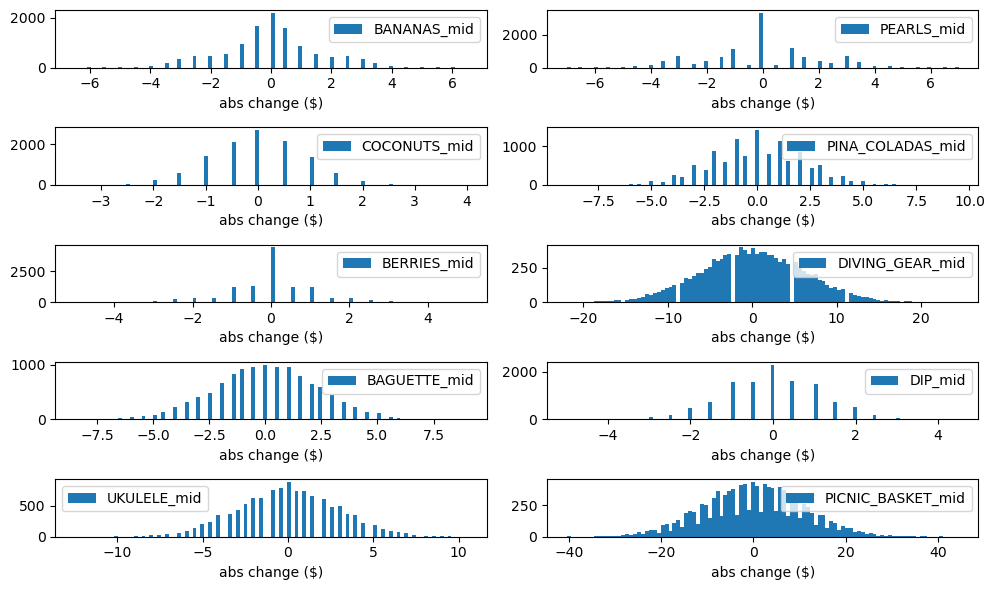

In [37]:
# distribution of price movements (pct change)

plt.figure(figsize=(10, 6))

mids = [f"{sym}_mid" for sym in _symbols]
cols = book_tops[mids]
diffs = (cols.shift(-1) - cols).dropna()

# show diffs stats
display(diffs.describe().T)


for sym_i, sym in enumerate(_symbols):
    
    mid = mids[sym_i]
    
    plt.subplot(5, 2, sym_i+1)

    plt.hist(diffs[mid], bins=100, label=mid)
    plt.xlabel("abs change ($)")
    plt.legend()
    
plt.tight_layout()
plt.show()


### Spread stats

BANANAS


,count,mean,std,min,25%,50%,75%,max
0,11515.0,5.169692,1.896131,1.0,5.0,6.0,6.0,7.0


PEARLS


,count,mean,std,min,25%,50%,75%,max
0,11515.0,6.731481,2.484025,2.0,6.0,8.0,8.0,10.0


COCONUTS


,count,mean,std,min,25%,50%,75%,max
0,11515.0,2.46053,0.610032,1.0,2.0,3.0,3.0,3.0


PINA_COLADAS


,count,mean,std,min,25%,50%,75%,max
0,11515.0,2.630135,0.596713,1.0,2.0,3.0,3.0,3.0


BERRIES


,count,mean,std,min,25%,50%,75%,max
0,11515.0,6.419887,1.251952,2.0,6.0,7.0,7.0,7.0


DIVING_GEAR


,count,mean,std,min,25%,50%,75%,max
0,11515.0,2.455667,0.521562,1.0,2.0,2.0,3.0,3.0


BAGUETTE


,count,mean,std,min,25%,50%,75%,max
0,11515.0,1.589492,0.491947,1.0,1.0,2.0,2.0,2.0


DIP


,count,mean,std,min,25%,50%,75%,max
0,11515.0,1.67703,0.467632,1.0,1.0,2.0,2.0,2.0


UKULELE


,count,mean,std,min,25%,50%,75%,max
0,11515.0,1.405645,0.491038,1.0,1.0,1.0,2.0,2.0


PICNIC_BASKET


,count,mean,std,min,25%,50%,75%,max
0,11515.0,11.324533,2.480359,1.0,11.0,12.0,13.0,14.0


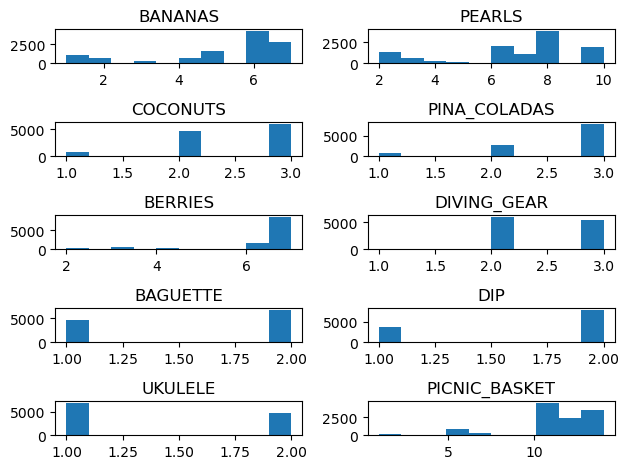

In [38]:
# spread summary stats

for sym_i, sym in enumerate(_symbols):
    print(sym)

    spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
    
    plt.subplot(5, 2, sym_i+1)
    plt.hist(spreads)
    plt.title(sym)
    display(spreads.describe().T)
    
plt.tight_layout()
plt.show()

In [39]:
# quantity stats
for sym in _symbols:
    df = trade_df[trade_df["symbol"] == sym]
    
    print(sym)
    display(df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T)

BANANAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,5508.0,3.748184,4.541033,1.0,1.0,1.0,1.0,2.0,4.0,11.0,20.0,35.0


PEARLS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,4906.0,2.893804,2.759237,1.0,1.0,1.0,1.0,2.0,4.0,7.0,12.0,21.0


COCONUTS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,590.0,43.725424,41.86788,2.0,5.0,7.0,10.0,33.0,59.0,118.0,159.33,225.0


PINA_COLADAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,523.0,27.208413,28.907114,1.0,2.0,3.0,5.0,20.0,35.0,81.0,106.0,138.0


BERRIES


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1253.0,8.99601,7.953488,1.0,1.0,2.0,4.0,8.0,12.0,17.0,30.0,89.0


DIVING_GEAR


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,821.0,2.014616,1.132569,1.0,1.0,1.0,1.0,2.0,3.0,3.0,5.0,18.0


BAGUETTE


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1616.0,7.477104,7.346664,2.0,2.0,2.0,4.0,5.0,8.0,15.0,36.0,43.0


DIP


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1813.0,11.60342,14.490041,3.0,3.0,4.0,5.0,8.0,10.0,20.0,71.88,90.0


UKULELE


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1371.0,4.028446,4.775996,1.0,1.0,1.0,2.0,3.0,5.0,7.0,18.0,74.0


PICNIC_BASKET


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1118.0,4.499106,4.600173,1.0,1.0,1.0,1.0,2.0,6.0,12.0,18.0,20.0


In [40]:
book_tops

,BAGUETTE_best_buy,BAGUETTE_best_sell,BAGUETTE_mid,BAGUETTE_spread,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,...,PICNIC_BASKET_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,UKULELE_best_buy,UKULELE_best_sell,UKULELE_mid,UKULELE_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,11999.0,12001.0,12000.0,2.0,4871.0,4877.0,4874.0,6.0,3916.0,3923.0,...,14.0,15013.0,15016.0,15014.5,3.0,20999.0,21001.0,21000.0,2.0,0
1,12001.0,12003.0,12002.0,2.0,4875.0,4877.0,4876.0,2.0,3916.0,3923.0,...,11.0,15012.0,15013.0,15012.5,1.0,21002.0,21004.0,21003.0,2.0,100
2,12002.0,12003.0,12002.5,1.0,4870.0,4876.0,4873.0,6.0,3916.0,3923.0,...,12.0,15015.0,15018.0,15016.5,3.0,21008.0,21009.0,21008.5,1.0,200
3,12003.0,12004.0,12003.5,1.0,4873.0,4875.0,4874.0,2.0,3916.0,3923.0,...,14.0,15014.0,15017.0,15015.5,3.0,21000.0,21001.0,21000.5,1.0,300
4,12003.0,12005.0,12004.0,2.0,4870.0,4871.0,4870.5,1.0,3917.0,3924.0,...,11.0,15012.0,15015.0,15013.5,3.0,21000.0,21001.0,21000.5,1.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11510,12238.0,12240.0,12239.0,2.0,4810.0,4816.0,4813.0,6.0,3858.0,3865.0,...,11.0,14871.0,14873.0,14872.0,2.0,20954.0,20955.0,20954.5,1.0,1151000
11511,12238.0,12240.0,12239.0,2.0,4809.0,4816.0,4812.5,7.0,3858.0,3865.0,...,11.0,14864.0,14867.0,14865.5,3.0,20952.0,20954.0,20953.0,2.0,1151100
11512,12237.0,12239.0,12238.0,2.0,4809.0,4816.0,4812.5,7.0,3857.0,3864.0,...,13.0,14865.0,14866.0,14865.5,1.0,20950.0,20951.0,20950.5,1.0,1151200


In [41]:
book_top_df = book_tops.melt(id_vars=["time"])

merge = lambda x : ("_".join(x[0:2]), x[2])
cols = book_top_df["variable"].apply(lambda x : x.split("_", 1) if (x.split("_", 1)[0] in _symbols) else merge(x.split("_", 2)))
cols = cols.apply(pd.Series).set_axis(["symbol", "variable"], axis=1)

book_top_df = book_top_df.drop("variable", axis=1).join(cols)


###  taker vs maker stats

In [42]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])


my_trade_df

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge,variable,value
0,,4875.0,1,SUBMISSION,BANANAS,100,100,2,True,False,True,-1,False,4873.5,-1.5,best_buy,4875.0
1,,10002.0,1,SUBMISSION,PEARLS,100,100,2,True,False,True,-1,False,10001.5,-0.5,best_buy,10002.0
2,,4875.0,1,SUBMISSION,BANANAS,200,200,3,True,False,True,-1,False,4873.0,-2.0,best_buy,4870.0
3,,10003.0,1,SUBMISSION,PEARLS,200,200,3,True,False,True,-1,False,10000.0,-3.0,best_buy,9996.0
4,,4873.0,1,SUBMISSION,BANANAS,300,300,4,True,False,True,-1,False,4871.5,-1.5,best_buy,4873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,,10002.0,3,SUBMISSION,PEARLS,1150500,1150500,11506,True,False,True,-3,False,10000.0,-2.0,best_buy,10002.0
10054,,10003.0,1,SUBMISSION,PEARLS,1150600,1150600,11507,True,False,True,-1,False,10000.0,-3.0,best_buy,9996.0
10055,,4816.0,1,SUBMISSION,BANANAS,1150600,1150600,11507,True,False,True,-1,False,4814.0,-2.0,best_buy,4811.0
10056,SUBMISSION,4811.0,8,,BANANAS,1150700,1150700,11508,True,True,False,8,False,4813.5,2.5,best_sell,4817.0


In [43]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


In [44]:
my_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
1,,4875.0,1,SUBMISSION,BANANAS,100,200,2,True,False,True,-1,False,4873.5,-1.5
3,,10002.0,1,SUBMISSION,PEARLS,100,200,2,True,False,True,-1,False,10001.5,-0.5
5,,4875.0,1,SUBMISSION,BANANAS,200,300,3,True,False,True,-1,False,4873.0,-2.0
8,,10003.0,1,SUBMISSION,PEARLS,200,300,3,True,False,True,-1,False,10000.0,-3.0
10,,4873.0,1,SUBMISSION,BANANAS,300,400,4,True,False,True,-1,False,4871.5,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22918,,10002.0,3,SUBMISSION,PEARLS,1150500,1150600,11506,True,False,True,-3,False,10000.0,-2.0
22921,,10003.0,1,SUBMISSION,PEARLS,1150600,1150700,11507,True,False,True,-1,False,10000.0,-3.0
22923,,4816.0,1,SUBMISSION,BANANAS,1150600,1150700,11507,True,False,True,-1,False,4814.0,-2.0
22925,SUBMISSION,4811.0,8,,BANANAS,1150700,1150800,11508,True,True,False,8,False,4813.5,2.5


BANANAS - my TAKER pnl: 7778.5


,count,mean,std,min,25%,50%,75%,max
my_edge,1951.0,1.581753,0.86668,-1.0,1.5,1.5,2.5,2.5


BANANAS - my MAKER pnl: 10654.0


,count,mean,std,min,25%,50%,75%,max
my_edge,1666.0,1.909964,0.70986,-1.5,1.5,2.0,2.5,2.5


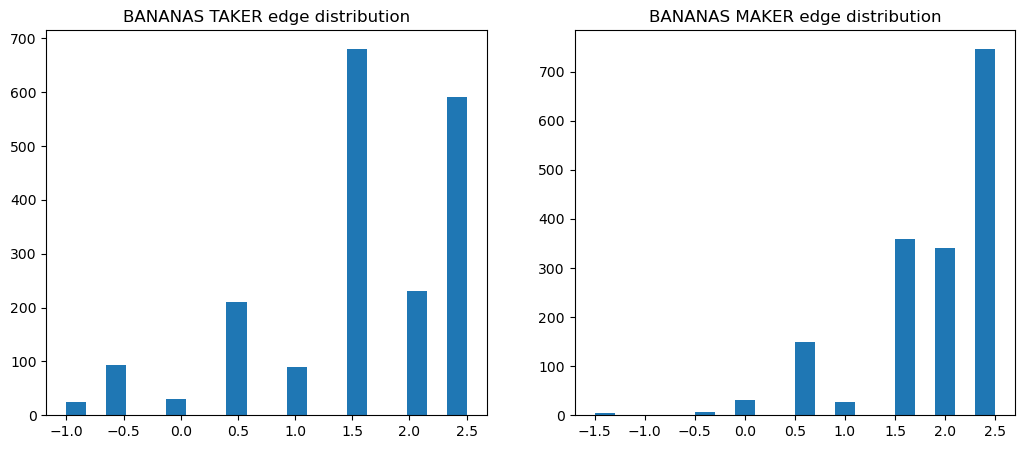

PEARLS - my TAKER pnl: 7456.0


,count,mean,std,min,25%,50%,75%,max
my_edge,2006.0,1.633101,0.745882,-0.5,2.0,2.0,2.0,2.0


PEARLS - my MAKER pnl: 9241.0


,count,mean,std,min,25%,50%,75%,max
my_edge,1326.0,2.551659,1.201795,-1.0,1.0,3.0,3.0,4.0


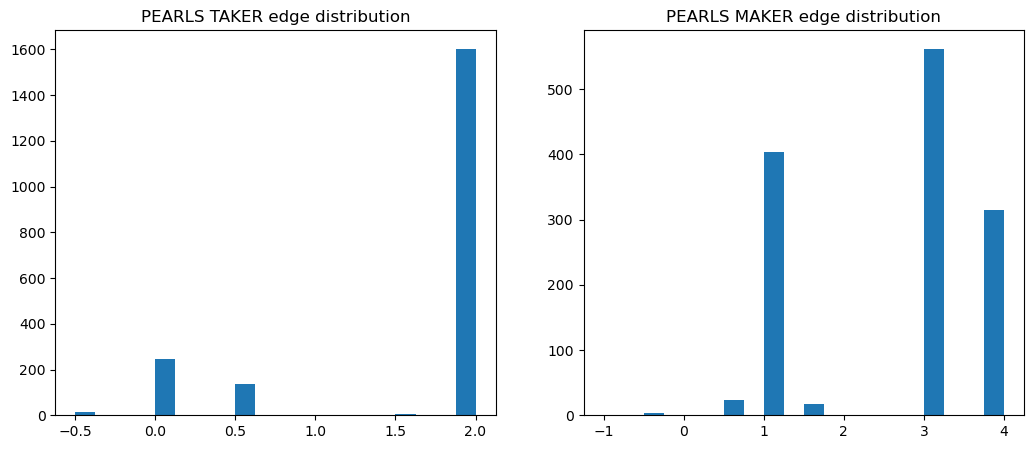

COCONUTS - my TAKER pnl: -19356.5


,count,mean,std,min,25%,50%,75%,max
my_edge,220.0,-1.045455,0.63045,-1.5,-1.5,-1.5,-0.5,0.5


COCONUTS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


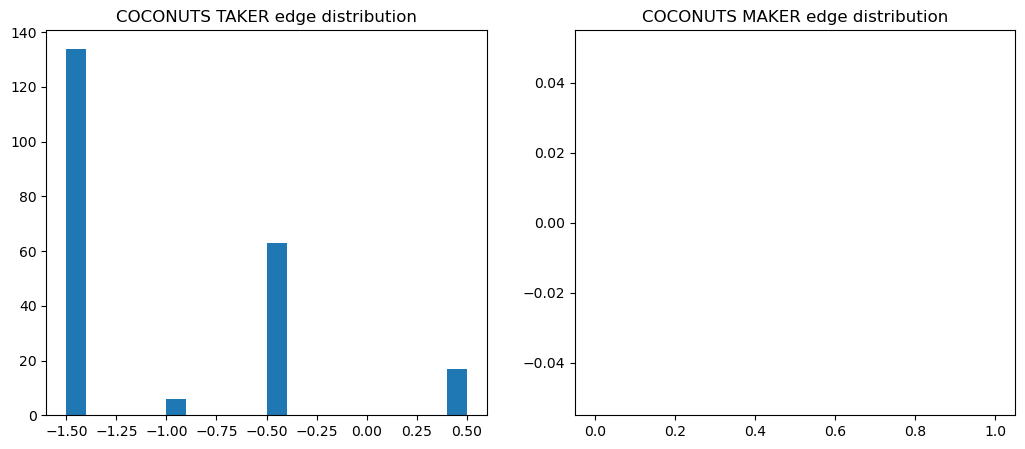

PINA_COLADAS - my TAKER pnl: -15435.5


,count,mean,std,min,25%,50%,75%,max
my_edge,219.0,-1.273973,0.509369,-2.0,-1.5,-1.5,-1.0,1.0


PINA_COLADAS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


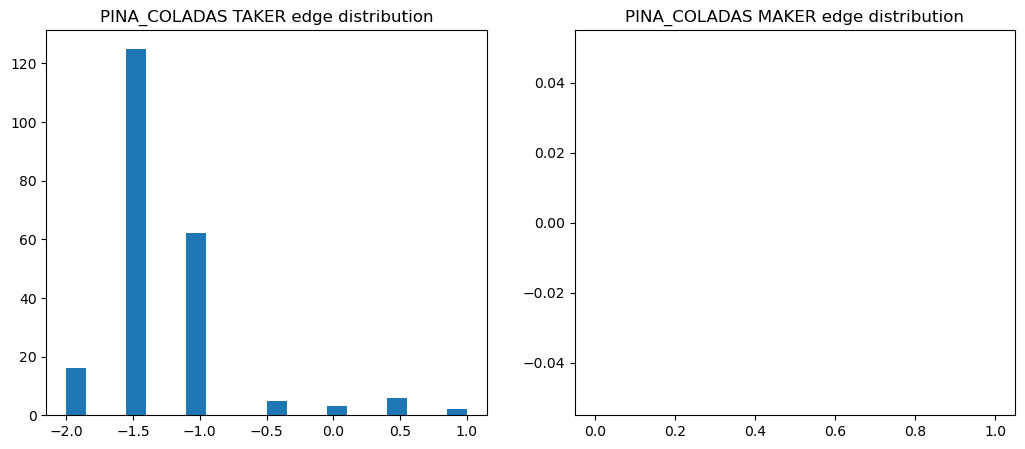

BERRIES - my TAKER pnl: -1539.5


,count,mean,std,min,25%,50%,75%,max
my_edge,361.0,0.350416,1.260426,-4.5,0.0,0.5,1.0,1.5


BERRIES - my MAKER pnl: 5374.0


,count,mean,std,min,25%,50%,75%,max
my_edge,259.0,2.432432,0.202385,2.0,2.5,2.5,2.5,3.0


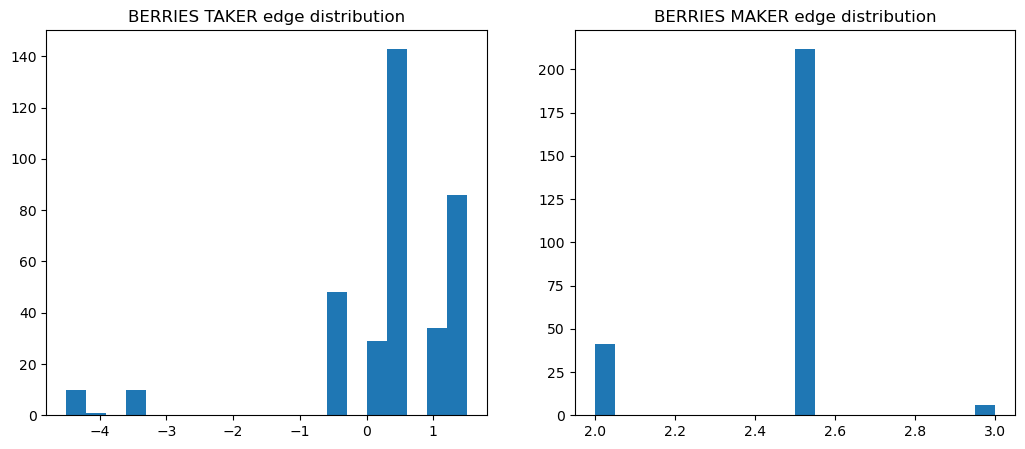

DIVING_GEAR - my TAKER pnl: -59.0


,count,mean,std,min,25%,50%,75%,max
my_edge,5.0,-1.1,0.223607,-1.5,-1.0,-1.0,-1.0,-1.0


DIVING_GEAR - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


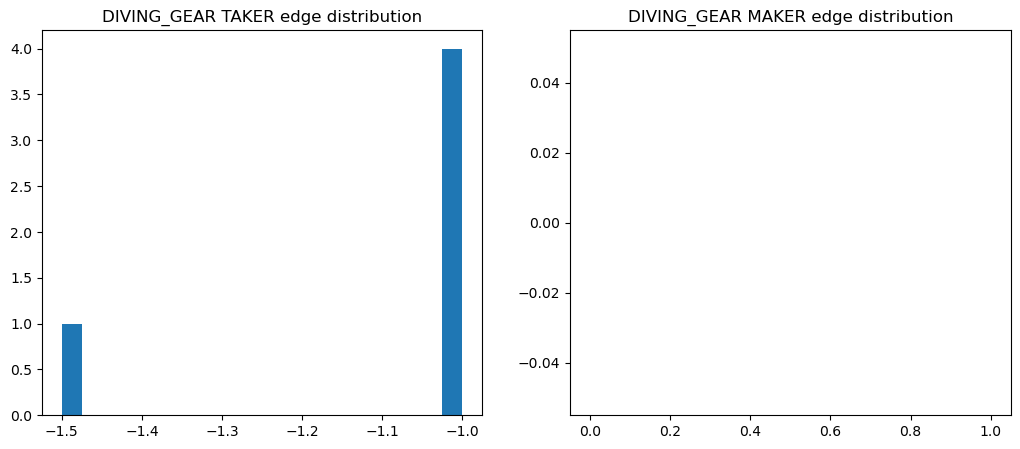

BAGUETTE - my TAKER pnl: -4606.0


,count,mean,std,min,25%,50%,75%,max
my_edge,595.0,-0.784034,0.402012,-1.5,-1.0,-0.5,-0.5,0.5


BAGUETTE - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


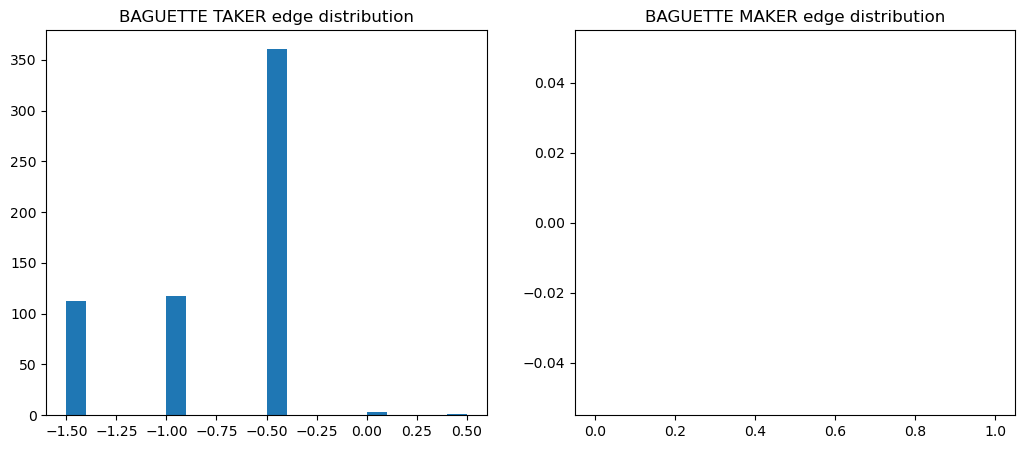

DIP - my TAKER pnl: -9611.0


,count,mean,std,min,25%,50%,75%,max
my_edge,595.0,-0.815966,0.298983,-1.5,-1.0,-1.0,-0.5,0.5


DIP - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


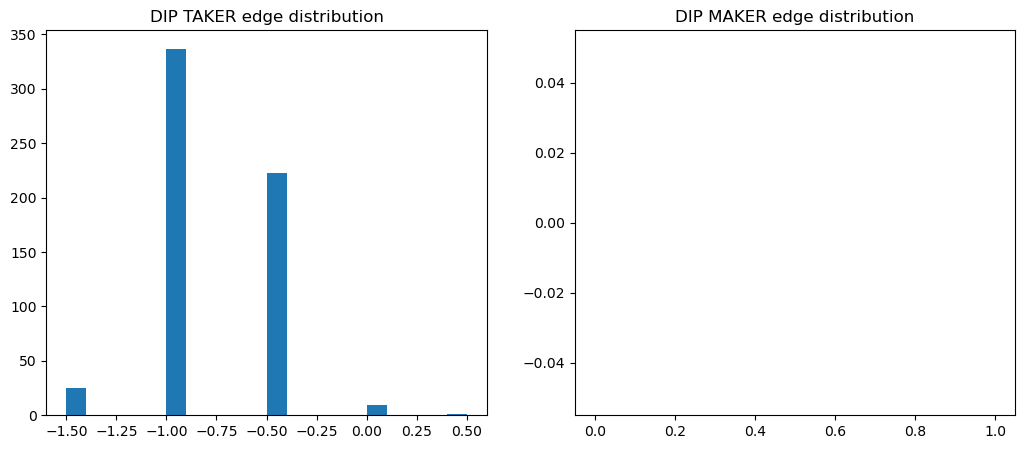

UKULELE - my TAKER pnl: -1298.5


,count,mean,std,min,25%,50%,75%,max
my_edge,260.0,-0.721154,0.435108,-1.0,-1.0,-1.0,0.0,0.0


UKULELE - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


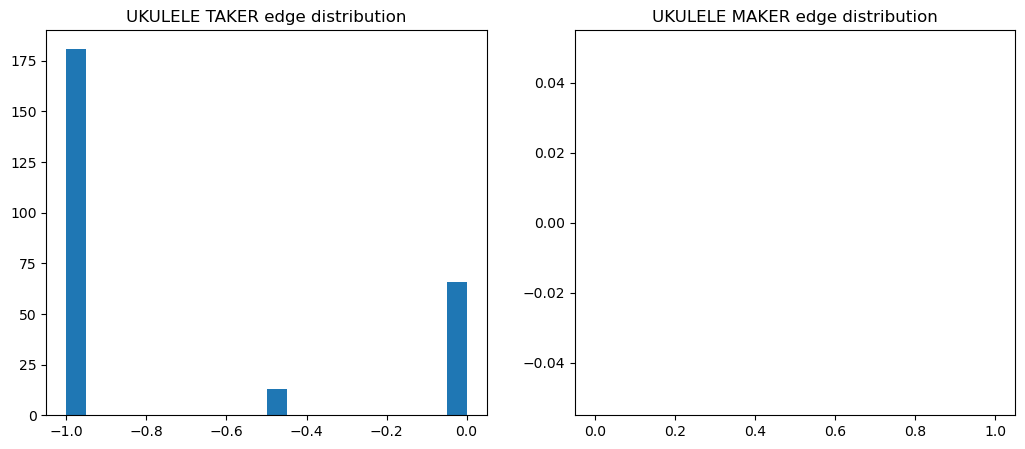

PICNIC_BASKET - my TAKER pnl: -17545.5


,count,mean,std,min,25%,50%,75%,max
my_edge,595.0,-5.456303,1.964913,-7.0,-6.0,-6.0,-5.5,6.0


PICNIC_BASKET - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


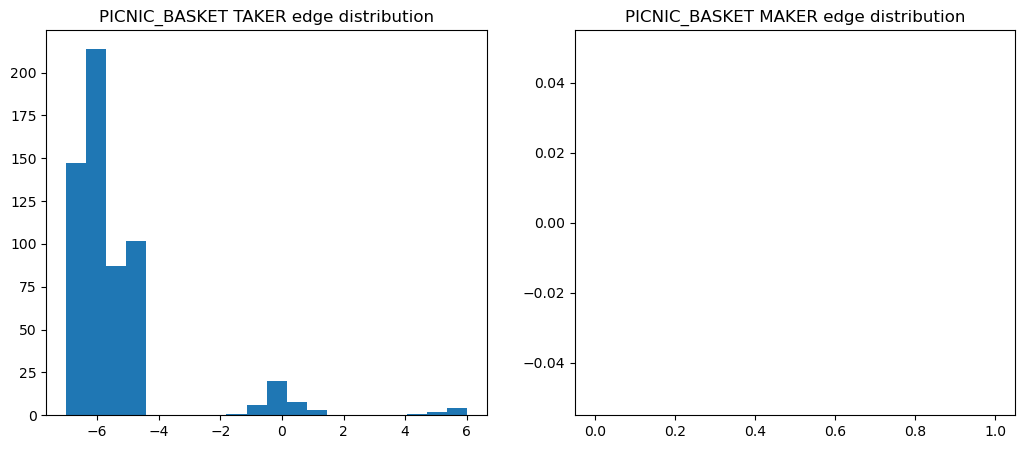

In [45]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


# drop cols
my_trade_df = my_trade_df.drop(["variable", "value"], axis=1)


# filter to keep only taker trades

# compute buy edge
my_trade_df["buy_edge"] = my_trade_df["fair_value"] - my_trade_df["price"]

# compute my edge
my_trade_df["my_edge"] = my_trade_df["buy_edge"] * np.sign(my_trade_df["my_quantity"])

# compute pnl
my_trade_df["pnl"] = my_trade_df["my_edge"] * my_trade_df["quantity"]

# filter by symbol
        
for sym in _symbols:
    the_df = my_trade_df[my_trade_df["symbol"] == sym]
    
    maker_df = the_df[~the_df["is_take"]]
    taker_df = the_df[the_df["is_take"]]
    

    # display pnl / stats for TAKER
    plt.figure(figsize=(12.5, 5))
    plt.subplot(121)
    print(sym, "- my TAKER pnl:", taker_df["pnl"].sum())

    display(taker_df[["my_edge"]].describe().T)

    plt.hist(taker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} TAKER edge distribution")
    
    
    # display pnl / stats for MAKER
    plt.subplot(122)
    print(sym, "- my MAKER pnl:", maker_df["pnl"].sum())

    display(maker_df[["my_edge"]].describe().T)

    plt.hist(maker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} MAKER edge distribution")
    plt.show()


In [46]:
my_trades[(my_trades["symbol"] == "BERRIES") & (my_trades["time"] < 1e5)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
42,SUBMISSION,3916.0,2,,BERRIES,1700,1800,18,True,True,False,2,False,3917.5,1.5
70,,3920.0,9,SUBMISSION,BERRIES,3200,3300,33,True,False,True,-9,False,3917.5,-2.5
75,SUBMISSION,3915.0,6,,BERRIES,3500,3600,36,True,True,False,6,False,3917.5,2.5
83,SUBMISSION,3915.0,10,,BERRIES,3700,3800,38,True,True,False,10,False,3917.0,2.0
107,,3919.0,4,SUBMISSION,BERRIES,5400,5500,55,True,False,True,-4,False,3917.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,SUBMISSION,3900.0,5,,BERRIES,97400,97500,975,True,True,False,5,False,3900.5,0.5
2062,SUBMISSION,3895.0,6,,BERRIES,98100,98200,982,True,True,False,6,False,3897.5,2.5
2077,,3901.0,1,SUBMISSION,BERRIES,98800,98900,989,True,False,True,-1,False,3899.0,-2.0
2094,,3898.0,2,SUBMISSION,BERRIES,99300,99400,994,True,False,True,-2,False,3898.0,0.0


### taker/maker optimization


- deciding whether to take/make:
    - current inventory (estimated)
    - common
        - cur_pos
    - taker:
        - info:
            - edge, quantity
        - actions
            - take all/ignore
            - take up to quantity
        - transition
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
    - maker:
        - info:
            - edge (the edge that we'd receive for placing an order at the best bid)
            - limit
        - actions
            - quantity up to limit
            
        - transition
            - randomized taken_quantity is selected
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
- state:
    - current inventory (

In [47]:
def rollout_action(cur_pos, limit, act):
    """
    Performs action given cur_pospotential action `act`
    
    Returns new_pos, pnl_change
    """
    
    edge = act["edge"]
    quantity = act["quantity"]
    is_buy = act["is_buy"]

    if edge == 0:
        # only take if it's good for us
        if is_buy:
            quantity = min(quantity, 0 - cur_pos)
        else:
            quantity = min(quantity, 0 + cur_pos)
    else:
        # take maximum
        if is_buy:
            quantity = min(quantity, limit - cur_pos)
        else:
            quantity = min(quantity, limit + cur_pos)

    # update state
    pnl_change = quantity * edge
    quantity_change = quantity if is_buy else -1 * quantity

    return cur_pos + quantity_change, pnl_change



### monte-carlo sim
def rollout(cur_pdf, limit, action_df):
    """
    Runs one MC rollout using the specified params
    
    Returns pnl_per_turn, ending_position
    """
    
    all_pdf = {i: 0 for i in range(-limit, limit + 1)}
    all_pnl = 0
    
    for cur_pos, cur_pos_prob in cur_pdf.items():
        if cur_pos_prob == 0:
            continue

        
        pdf = {i: 0 for i in range(-limit, limit + 1)}
        # if we don't take any taker_df trades, we will remain in this position
        pdf[cur_pos] = 1 - action_df["freq"].sum()

        # trade_pnl will contain expected pnl from trading when we start at 'cur_pos'
        trade_pnl = 0

        # iterate through actions
        for index, row in action_df.iterrows():
            new_pos, pnl_diff = rollout_action(cur_pos, limit, row)

            # get pnl from trade
            trade_pnl += pnl_diff * row["freq"]
            pdf[new_pos] += row["freq"]
            
        # pnl contains total profits from edge up to this point
#         print("trade pnl", cur_pos, trade_pnl)
        
        # update all_pnl
        all_pnl += trade_pnl * cur_pos_prob
        
        # update all_pdf
        for next_pos, next_pos_prob in pdf.items():
            all_pdf[next_pos] += next_pos_prob * cur_pos_prob
            
    return all_pnl, all_pdf

In [48]:
# hyper-params
def get_markov_chain(sym, limit, rollout_length):

    num_turns = _max_time / _time_step

    # create taker_df
    taker_df = order_df[order_df["symbol"] == sym]
    taker_df = taker_df[taker_df["taker_edge"] >= 0]
    taker_df = taker_df[["quantity", "taker_edge"]].copy().rename({"taker_edge": "edge"}, axis=1)

    taker_df["is_buy"] = ~(taker_df["quantity"] > 0) # we can perform the opposite trade against this quantity
    taker_df["quantity"] = taker_df["quantity"].abs()
    taker_df["edge"] = taker_df["edge"].abs() # convert -0 to 0

    # create order_df
    the_df = my_trade_df[(my_trade_df["symbol"] == sym)]
    maker_df = the_df[~the_df["is_take"]]
    maker_df = maker_df[["quantity", "my_edge", "my_buy"]].rename({"my_buy": "is_buy", "my_edge": "edge"}, axis=1)

    # calculate pnl
    taker_df["pnl"] = taker_df["edge"] * taker_df["quantity"]
    maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

    # print stats abt taker/maker

    print("taker chance", len(taker_df) / num_turns)
    print("maker chance", len(maker_df) / num_turns)
    print("market_trade chance", len(market_trades) / num_turns)

    # print taker profits

    print("Taker total edge by side")
    display(taker_df.groupby("is_buy")["pnl"].sum())

    print("Maker total edge by side")
    display(maker_df.groupby("is_buy")["pnl"].sum())



    # calculate taker stats
    taker_stats = taker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    taker_stats["freq"] /= num_turns

    maker_stats = maker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    maker_stats["freq"] /= num_turns

    print("len(taker_stats)", len(taker_stats))
    print("len(maker_stats)", len(maker_stats))


    ## calculate transition matrices
    trade_pnls = {}
    next_pdfs = {}

    for cur_pos in range(-limit, limit + 1):
        # setup initial cur_pdf
        cur_pdf = {i: 0 for i in range(-limit, limit + 1)}
        cur_pdf[cur_pos] = 1

        # rollout on taker
        taker_pnl, pdf1 = rollout(
            cur_pdf=cur_pdf,
            limit=limit,
            action_df=taker_stats,
        )

        # rollout on maker
        maker_pnl, pdf2 = rollout(
            cur_pdf=pdf1,
            limit=limit,
            action_df=maker_stats,
        )

        trade_pnls[cur_pos] = taker_pnl + maker_pnl
        next_pdfs[cur_pos] = pdf2

    # get A - transition probability matrix
    # a_ij is prob of going from j to i
    trans_prob_df = pd.DataFrame(next_pdfs)
    A = trans_prob_df.to_numpy()

    # each row should sum to 1
    assert np.all(abs(A.sum(axis=0) - 1) <= 1e-5)

    # get D - transition income matrix
    trans_pnl_df = pd.DataFrame(trade_pnls.items(), columns=["cur_pos", "pnl"])
    trans_pnl_df = trans_pnl_df.sort_values(by="cur_pos")

    D = trans_pnl_df["pnl"].to_numpy()

    return A, D

In [49]:
# calculate scores
def score_matrix(A, D, limit):
    scores = {}

    for cur_pos in range(-limit, limit + 1):
        # init cur_pdf
        cur_pdf = np.zeros((2 * limit + 1, 1))
        cur_pdf[cur_pos + limit, 0] = 1

        pnl = 0

        # iterate for rollout number of times
        for i in range(rollout_length):
            trade_pnl = np.dot(D, cur_pdf).item()
            cur_pdf = A @ cur_pdf

            pnl += trade_pnl

        scores[cur_pos] = pnl
        
    score_df = pd.DataFrame(scores.items(), columns=["start_pos", "pnl"])
    score_df = score_df.set_index("start_pos")
    score_df["pnl_diff"] = score_df["pnl"] - score_df["pnl"].loc[0]
    score_df["pnl_diff_rev"] = list(score_df["pnl_diff"].iloc[::-1])
    score_df["pnl_norm"] = (score_df["pnl_diff_rev"] + score_df["pnl_diff"]) / 2
    
    return score_df

In [50]:
# show scores for each position
rollout_length = 1000
limit = 70
sym = "PICNIC_BASKET"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

NameError: name 'order_df' is not defined

In [ ]:
# show scores for each position
rollout_length = 1000
limit = 250
sym = "BERRIES"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

In [ ]:
# show scores for each position
rollout_length = 1000
limit = 20
sym = "BANANAS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

In [ ]:
# show scores for each position
rollout_length = 1000
limit = 20
sym = "PEARLS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

### Available Taker edge

In [ ]:
# calculate available taker edge

avail_taker_df = order_df[order_df["taker_edge"] > 0].copy()
avail_taker_df["pnl"] = avail_taker_df["taker_edge"] * avail_taker_df["quantity"].abs()

for sym in _symbols:
    df = avail_taker_df[avail_taker_df["symbol"] == sym]
    print(f"Available taker edge in {sym}", df["pnl"].sum().round())



### missed takers


In [ ]:

# get avail taker trades + my taker trades
avail_df = avail_taker_df
my_df = my_trade_df[my_trade_df["is_take"]]

# filter columns
my_df = my_df[["time", "symbol", "price", "my_quantity"]]
avail_df = avail_df[["time", "symbol", "price", "quantity", "taker_edge", "fair_value"]]

# see which avail taker trades were actually taken by me
taker_df = avail_df.merge(my_df, how="left", on=["time", "symbol", "price"])

taker_df["my_quantity"] = taker_df["my_quantity"].fillna(0)

# ensure my_quantity is not the same sign of resting order quantity
wrongs = (taker_df["my_quantity"] == taker_df["quantity"])
assert(wrongs.sum() == 0)
# display(taker_df[wrongs])

# calculate taken vs avail size
taker_df["avail_size"] = taker_df["quantity"].abs()
taker_df["taken_size"] = np.minimum(taker_df["my_quantity"].abs(), taker_df["avail_size"])
taker_df["missed_size"] = taker_df["avail_size"] - taker_df["taken_size"]

# calculate taken vs avail pnl
taker_df["avail_pnl"] = taker_df["taker_edge"] * taker_df["avail_size"]
taker_df["taken_pnl"] = taker_df["taker_edge"] * taker_df["taken_size"]
taker_df["missed_pnl"] = taker_df["taker_edge"] * taker_df["missed_size"]

for sym in _symbols:
    df = taker_df[taker_df["symbol"] == sym]
    
    print(sym, "taken_pnl", df["taken_pnl"].sum())
    print(sym, "avail_pnl", df["avail_pnl"].sum())
    print(sym, "missed_pnl", df["missed_pnl"].sum())
    print()
    print(sym, "taken_size", df["taken_size"].sum())
    print(sym, "avail_size", df["avail_size"].sum())
    print(sym, "missed_size", df["missed_size"].sum())
    print()


In [ ]:
# missed takers
my_pos_df = my_positions.melt(id_vars=["time"], value_vars=_symbols, var_name="symbol", value_name="cur_pos")

untaken_df = taker_df[taker_df["avail_size"] != taker_df["taken_size"]]

# untaken_df = untaken_df[["time", "symbol", "price", "fair_value", "taker_edge", "avail_size", "taken_size"]].merge(my_pos_df, on=["time", "symbol"])
untaken_df = untaken_df.merge(my_pos_df, on=["time", "symbol"])

for sym in _symbols:
    df = untaken_df[untaken_df["symbol"] == sym].drop(["my_quantity"], axis=1)
    
    display(df)
    
    

### Available maker edge

In [ ]:
# calculate market maker edge (maker edge that the market received)
maker_df = market_trades.copy()

maker_df["edge"] = maker_df["buy_edge"].abs()
maker_df["pnl"] = maker_df["quantity"] * maker_df["edge"]

for sym in _symbols:
    df = maker_df[maker_df["symbol"] == sym]
    print(f"Remaining maker edge in {sym}", df["pnl"].sum().round())
    

In [ ]:
df.diff(axis=1)

In [ ]:
# load data from file

obj = process_file(_fname, start_sep="__custom", end_sep="__end")

df = pd.DataFrame(obj)
df.columns = df.columns.astype(int)

diff_df = df.diff(1, axis=1)

In [ ]:
for i in [0, 1000, 3000, 3333, 3500, 4500, 4950]:
    plt.plot(diff_df.loc[i], label=i)
    
plt.legend()

In [ ]:
df = pd.read_csv("../replays/round3-results.csv", sep=";")
dol_df = df[df["product"] == "DOLPHIN_SIGHTINGS"].reset_index(drop=True).copy()
df = df[df["product"] == "DIVING_GEAR"].reset_index(drop=True)


In [ ]:
df["est_pos"] = df["profit_and_loss"].diff(1) / df["mid_price"].diff(1)

In [ ]:
dol_df["dol_diff"] = dol_df["mid_price"].diff(1)
dol_df[dol_df["dol_diff"].abs() > 1]

In [ ]:
dol_df

In [ ]:
ax = plt.gca()
ax.plot(df["mid_price"])
ax2 = ax.twinx()
ax2.plot(dol_df["mid_price"], color="orange")
dol_df[dol_df["dol_diff"].abs() > 1]

In [ ]:
ax = plt.gca()
ax.plot(df["profit_and_loss"])
ax2 = ax.twinx()
ax2.plot(df["est_pos"].rolling(10).mean(), color="red")
ax2.axhline(y=0)

In [ ]:
import json
with open("../replays/round3-official.json") as f:
    obj = json.load(f)

trade_df = pd.DataFrame(obj["tradeHistory"])

my_buys = trade_df[trade_df["buyer"] == "SUBMISSION"]
my_sells = trade_df[trade_df["seller"] == "SUBMISSION"].copy()

my_sells["quantity"] *= -1
my_trades = pd.concat([my_buys, my_sells])

my_trades = my_trades[my_trades["symbol"] == "DIVING_GEAR"]

my_trades = my_trades.sort_values(by="timestamp")

# my_trades = my_trades.groupby("timestamp")[["timestamp", "quantity"]].sum()

my_trades["pos"] = my_trades["quantity"].cumsum()


In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(my_trades["quantity"].cumsum())

In [ ]:
my_trades.groupby("timestamp")["quantity"].sum()

In [ ]:
my_trades

In [ ]:
plt.plot(my_trades["quantity"].cumsum())